In [81]:
import FundamentalAnalysis as fa 
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import yfinance as yf

In [375]:
ticker = "AMD" #ticker name
api = "f9faa25f52d06b99069edd4a6fb499a9" #api key

#get company profile for beta calculation and marketcap
profile = fa.profile(ticker, api)
quote = fa.quote(ticker, api)

#FMP gives the dates reversed and hence the need for
#the .iloc in all the data calls
fra = fa.financial_ratios(ticker, api, period="annual").iloc[:,::-1] #get the annual financial ratios (past 5 years)
frq = fa.financial_ratios(ticker, api, period="quarter").iloc[:,::-1] #get the past 5 quarters
dcf = fa.discounted_cash_flow(ticker, api).iloc[:,::-1] #get the pre-calculated dcf model

#get the cash flow, income statement, and balance sheet
cf = fa.cash_flow_statement(ticker, api).iloc[:,::-1]
ins = fa.income_statement(ticker, api).iloc[:,::-1]
bs = fa.balance_sheet_statement(ticker, api).iloc[:,::-1]

year = "2019" #set year

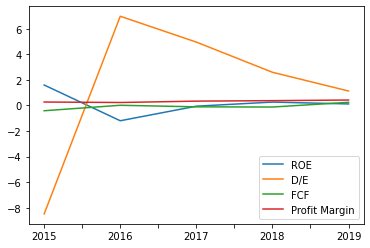

In [376]:
qoa = fra

#plot out key ratios
qoa.loc["returnOnEquity"].plot(label="ROE")
qoa.loc["debtEquityRatio"].plot(label="D/E")
qoa.loc["freeCashFlowPerShare"].plot(label="FCF")
qoa.loc["grossProfitMargin"].plot(label="Profit Margin")

plt.legend()

In [377]:
dcf_proj = pd.DataFrame({
    "revenue" : ins.loc["revenue"],
    "netincome" : cf.loc["netIncome"],
    "freecash" : cf.loc["freeCashFlow"]
}).transpose()

dcf_proj.loc["incomeMargin"] = dcf_proj.loc["revenue"]/dcf_proj.loc["netincome"]
dcf_proj.loc["FCFr"] = dcf_proj.loc["revenue"]/dcf_proj.loc["freecash"]
rev_change = ins.loc["revenue"].pct_change().mean()
margin_change = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()
fcf_change = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()

In [378]:
startrev = dcf_proj.loc["revenue",year]
startneti = dcf_proj.loc["netincome",year]
startfcf = dcf_proj.loc["freecash",year]

#creating projections for a 5 year dcf model
Fiveyrev = []
Fiveyinc = []
Fiveyfcf = []
for i in range(5):
    startrev = startrev*(1+rev_change)
    neti = startrev*(margin_change/100)
    fcf = neti*(fcf_change/100)
    Fiveyrev.append(startrev)
    Fiveyinc.append(neti)
    Fiveyfcf.append(fcf)

In [379]:
dcf_calc = pd.DataFrame({
    "ProjRev" : Fiveyrev,
    "ProjInc" : Fiveyinc,
    "ProjFCF" : Fiveyfcf
})

In [380]:
tnx = yf.Ticker("^TNX") #use yfinance to get the 10yr treasury bond return
rfr = tnx.info["previousClose"] #use previousclose to estimate rfr

beta = profile.loc["beta"] #get beta of stock from stock profile
mktCap = quote.loc["marketCap"] #market cap of stock
totdebt = bs.loc["totalDebt",year] #total debt
sharesOut = quote.loc["sharesOutstanding"]
pg = 0.025

Rd = ins.loc["interestExpense", year]/totdebt*(1-(ins.loc["incomeTaxExpense",year]/ins.loc["incomeBeforeTax",year]))
Re = rfr + (beta*(10 - rfr))
# Wacc = ((Rd)*(totdebt/(mktCap + totdebt)) + (Re)*(1-(totdebt/(mktCap + totdebt))))/100
Wacc = 0.075

TV = float(((Fiveyfcf[-1]*(1+pg))/(Wacc - pg)))
Fiveyfcf.append(TV)

Fiveyfcfdisc = []

for i,d in enumerate(Fiveyfcf):
    disc = float(Fiveyfcf[i]) * (1+Wacc)**(1+i)
    Fiveyfcfdisc.append(disc)

FV = float(sum(Fiveyfcfdisc))/sharesOut

In [394]:
def fairvalue(ticker_name, api_key, manual_mode = "no", man_initial_revenue=None, man_rev_growth=None, RR_calc = "manual", RR_manual = 0.075, risk_free_rate_ticker="^TNX", risk_free_rate = 0.94, perpGrowth = 0.025, year="2019"):
    """
    This function helps to determine the Fair Value
    of a stock using the Discounted Cash Flow Model.

    Set manual_mode to "yes" to enter your own numbers
    for initial revenue (in thousands) and revenue growth, 
    Take note that you will still have to provide dataframes 
    since other data like IncomeExpense etc. will still 
    be automatically pulled from the balance sheet.
    """
    
    ticker = ticker_name #ticker name
    api = api_key #api key

    #get company profile for beta calculation and marketcap
    stkProf = fa.profile(ticker, api)
    stkQuote = fa.quote(ticker, api)

    #get the cash flow, income statement, and balance sheet
    stkCash = fa.cash_flow_statement(ticker, api).iloc[:,::-1]
    stkInc = fa.income_statement(ticker, api).iloc[:,::-1]
    stkBal = fa.balance_sheet_statement(ticker, api).iloc[:,::-1]

    if manual_mode == "no":
        dcf_proj = pd.DataFrame({
        "revenue" : stkInc.loc["revenue"],
        "netincome" : stkCash.loc["netIncome"],
        "freecash" : stkCash.loc["freeCashFlow"]
        }).transpose()

        auto_initial_revenue = dcf_proj.loc["revenue",year]

        dcf_proj.loc["incomeMargin"] = dcf_proj.loc["revenue"]/dcf_proj.loc["netincome"]
        dcf_proj.loc["FCFr"] = dcf_proj.loc["revenue"]/dcf_proj.loc["freecash"]
        auto_rev_growth = ins.loc["revenue"].pct_change().mean()
        auto_incomeMargin = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()
        auto_revOverfcf = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()

        Fiveyrev = []
        Fiveyinc = []
        Fiveyfcf = []
        for i in range(5):
            auto_initial_revenue = auto_initial_revenue*(1+auto_rev_growth)
            neti = auto_initial_revenue*(auto_incomeMargin/100)
            fcf = neti*(auto_revOverfcf/100)
            Fiveyrev.append(auto_initial_revenue)
            Fiveyinc.append(neti)
            Fiveyfcf.append(fcf)
        
        try:
            tnx = yf.Ticker(risk_free_rate_ticker) 
            rfr = tnx.info["previousClose"] 
        except:
            rfr = risk_free_rate

        beta = stkProf.loc["beta"]
        mktCap = stkQuote.loc["marketCap"] 
        totdebt = stkBal.loc["totalDebt",year]
        sharesOut = stkQuote.loc["sharesOutstanding"]
        pg = perpGrowth

        Rd = stkInc.loc["interestExpense", year]/totdebt*(1-(stkInc.loc["incomeTaxExpense",year]/stkInc.loc["incomeBeforeTax",year]))
        Re = rfr + (beta*(10 - rfr))

        if RR_calc=="wacc":
            RR_wacc = ((Rd)*(totdebt/(mktCap + totdebt)) + (Re)*(1-(totdebt/(mktCap + totdebt))))/100
            TV = float(((Fiveyfcf[-1]*(1+pg))/(RR_wacc - pg)))
            Fiveyfcf.append(TV)

            Fiveyfcfdisc = []

            for i,d in enumerate(Fiveyfcf):
                disc = float(Fiveyfcf[i]) * (1+RR_wacc)**(1+i)
                Fiveyfcfdisc.append(disc)

            FV = float(sum(Fiveyfcfdisc))/sharesOut

            return FV
        
        
        elif RR_calc=="manual": 
            RR = RR_manual
            TV = float(((Fiveyfcf[-1]*(1+pg))/(RR - pg)))
            Fiveyfcf.append(TV)

            Fiveyfcfdisc = []

            for i,d in enumerate(Fiveyfcf):
                disc = float(Fiveyfcf[i]) * (1+RR)**(1+i)
                Fiveyfcfdisc.append(disc)

            FV = float(sum(Fiveyfcfdisc))/sharesOut

            return FV

    elif manual_mode=="yes":

        dcf_proj = pd.DataFrame({
        "revenue" : stkInc.loc["revenue"],
        "netincome" : stkCash.loc["netIncome"],
        "freecash" : stkCash.loc["freeCashFlow"]
        }).transpose()

        dcf_proj.loc["incomeMargin"] = dcf_proj.loc["revenue"]/dcf_proj.loc["netincome"]
        dcf_proj.loc["FCFr"] = dcf_proj.loc["revenue"]/dcf_proj.loc["freecash"]
        auto_incomeMargin = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()
        auto_revOverfcf = dcf_proj.loc["incomeMargin", dcf_proj.loc["incomeMargin"] > 0].min()

        Fiveyrev = []
        Fiveyinc = []
        Fiveyfcf = []
        for i in range(5):
            man_initial_revenue = man_initial_revenue*(1+man_rev_growth)
            neti = man_initial_revenue*(auto_incomeMargin/100)
            fcf = neti*(auto_revOverfcf/100)
            Fiveyrev.append(man_initial_revenue)
            Fiveyinc.append(neti)
            Fiveyfcf.append(fcf)
        
        try:
            tnx = yf.Ticker(risk_free_rate_ticker) 
            rfr = tnx.info["previousClose"] 
        except:
            rfr = risk_free_rate

        beta = stkProf.loc["beta"]
        mktCap = stkQuote.loc["marketCap"] 
        totdebt = stkBal.loc["totalDebt",year]
        sharesOut = stkQuote.loc["sharesOutstanding"]
        pg = perpGrowth

        Rd = stkInc.loc["interestExpense", year]/totdebt*(1-(stkInc.loc["incomeTaxExpense",year]/stkInc.loc["incomeBeforeTax",year]))
        Re = rfr + (beta*(10 - rfr))

        if RR_calc=="wacc":
            RR_wacc = ((Rd)*(totdebt/(mktCap + totdebt)) + (Re)*(1-(totdebt/(mktCap + totdebt))))/100
            TV = float(((Fiveyfcf[-1]*(1+pg))/(RR_wacc - pg)))
            Fiveyfcf.append(TV)

            Fiveyfcfdisc = []

            for i,d in enumerate(Fiveyfcf):
                disc = float(Fiveyfcf[i]) * (1+RR_wacc)**(1+i)
                Fiveyfcfdisc.append(disc)

            FV = float(sum(Fiveyfcfdisc))/sharesOut

            return FV
        
        
        elif RR_calc=="manual": 
            RR = RR_manual
            TV = float(((Fiveyfcf[-1]*(1+pg))/(RR - pg)))
            Fiveyfcf.append(TV)

            Fiveyfcfdisc = []

            for i,d in enumerate(Fiveyfcf):
                disc = float(Fiveyfcf[i]) * (1+RR)**(1+i)
                Fiveyfcfdisc.append(disc)

            FV = float(sum(Fiveyfcfdisc))/sharesOut

            return FV
            

In [343]:
np.random.normal(0.075,0.001)

0.07295900134839958

In [397]:
fairvalue(ticker_name="AMD", api_key=api, manual_mode="yes", man_initial_revenue=(10*1000000000), man_rev_growth=0.52, RR_calc="manual", RR_manual=0.075)

0    87.117
Name: sharesOutstanding, dtype: object